### Cats vs Dogs classification

The model trained will be a small model to set the bear minimun model to compare with other models develop and trained later

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus=tf.config.list_physical_devices('GPU')

#configure the GPU(s), to use the memory necessary up to the GPU max memory
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
            print(tf.config.experimental.get_device_details(gpu))
        logi_gpu=tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus),'Physical GPU(s)',len(logi_gpu),'Logical GPU(s)')
        
    except RuntimeError as e:
        print(e)
print("Is gpu available?, :",tf.test.is_gpu_available(cuda_only=False,min_cuda_compute_capability=None))

Num GPUs Available:  1
{'device_name': 'NVIDIA GeForce RTX 2060', 'compute_capability': (7, 5)}
1 Physical GPU(s) 1 Logical GPU(s)
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is gpu available?, : True


In [2]:
# it will be used 2000 images for trainign, 1000 images for validation and
#1000 images for testing
import os
import random
import shutil

def create_dataset(origin,folder,ratio,num_ob,name_folders,clas,seed=0):
    #origin where the data is going to be extracted
    #folder where the data is going to be copied
    #ratio how many classes and it's respective representative on the num_ob
    #num_ob is the numeber of objects where is going to be extracted
    #seed is the random generator seed
    #clas is the number of classes and what determines a class (name, number,...)
    if len(ratio)!=len(name_folders):
        raise("Ratio and name_folders must have same dimmensions")
    if sum(ratio)!=100:
        raise("Ratio should sum 100%")
    if not os.path.isdir(origin):
        raise("Origin is not a proper directory")


    random.seed(seed)
    I_obj=os.listdir(origin)

    for i,r in zip(name_folders,ratio):
        dir=os.path.join(folder,i)
        os.makedirs(dir,exist_ok=True)#create diretory if it doesn't exists

        files=num_ob*r//100#files per folder
        if len(clas)>1:
            for j,c in enumerate(clas):#iterate throghout the different classes
                files_c=files//len(clas)#files per class
                cont=0
                dir_c=os.path.join(dir,c)
                os.makedirs(dir_c,exist_ok=True)
                while cont<files_c:#pass 
                    f=random.choice(I_obj)
                    if f.startswith(c):
                        of=os.path.join(origin,f)
                        ff=os.path.join(dir_c,f)
                        if os.path.exists(of) and os.path.exists(ff)==False:
                            cont+=1
                            shutil.copy(of,ff)
                print("Finish copying {} elements to folder {},class:{}".format(cont,i,c))
        else:
            cont=0
            while cont<num_ob:#pass 
                f=random.choice(I_obj)
                of=os.path.join(origin,f)
                ff=os.path.join(dir,f)
                if os.path.exists(of) and os.path.exists(ff)==False:
                    cont+=1
                    shutil.copy(of,ff)
            print("Finish copying {} elements to folder {},class:{}".format(cont,i,c))
        
    print("Finish copying all elements")         
         
create_dataset("CatsvsDogs_dataset\\train",
               "CatsvsDogs_small_dataset",
               [50,25,25],
               4000,
               ("Train","Validation","Test"),
               ("cat","dog"),
               seed=0)


Finish copying 1000 elements to folder Train,class:cat
Finish copying 1000 elements to folder Train,class:dog
Finish copying 500 elements to folder Validation,class:cat
Finish copying 500 elements to folder Validation,class:dog
Finish copying 500 elements to folder Test,class:cat
Finish copying 500 elements to folder Test,class:dog
Finish copying all elements


In [3]:
#defying the small convnet model
from keras import models, layers
small_model=models.Sequential()
small_model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(150,150,3)))
small_model.add(layers.MaxPooling2D((2,2)))
small_model.add(layers.Conv2D(64,(3,3),activation="relu"))
small_model.add(layers.MaxPooling2D((2,2)))
small_model.add(layers.Conv2D(128,(3,3),activation="relu"))
small_model.add(layers.MaxPooling2D((2,2)))
small_model.add(layers.Conv2D(128,(3,3),activation="relu"))
small_model.add(layers.MaxPooling2D((2,2)))
small_model.add(layers.Flatten())
small_model.add(layers.Dense(512,activation="relu"))
small_model.add(layers.Dense(1,activation="sigmoid"))
small_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [4]:
#configure(comile step) the model for training
from keras import optimizers
small_model.compile(loss="binary_crossentropy",
                    optimizer=optimizers.RMSprop(learning_rate=1e-4),
                    metrics=["acc"])

In [5]:
#using imagedatagenerator to read images from directory
from keras.preprocessing.image import ImageDataGenerator
train_d=ImageDataGenerator(rescale=1./255)
test_d=ImageDataGenerator(rescale=1./255)
val_d=ImageDataGenerator(rescale=1./255)
train_g=train_d.flow_from_directory("CatsvsDogs_small_dataset\Train",
                                    target_size=(150,150),batch_size=20,
                                    class_mode="binary")
val_g=val_d.flow_from_directory("CatsvsDogs_small_dataset\Validation",
                                    target_size=(150,150),batch_size=20,
                                    class_mode="binary")
test_g=test_d.flow_from_directory("CatsvsDogs_small_dataset\Test",
                                    target_size=(150,150),batch_size=20,
                                    class_mode="binary")
print("Data batch shape:",train_g[0][0].shape)
print("labels batch shape:",train_g[0][1].shape)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [6]:
#Fitting or training the small model
history=small_model.fit_generator(train_g,steps_per_epoch=100,
                                  epochs=30,validation_data=val_g,validation_steps=50)
small_model.save("CatsvsDogs_small_model.h5")

C:\Users\simon\AppData\Local\Temp\ipykernel_29916\4138325629.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=small_model.fit_generator(train_g,steps_per_epoch=100,


Epoch 1/30
100/100 [==============================] - 24s 177ms/step - loss: 0.6875 - acc: 0.5430 - val_loss: 0.6694 - val_acc: 0.6410
Epoch 2/30
100/100 [==============================] - 4s 41ms/step - loss: 0.6589 - acc: 0.5995 - val_loss: 0.6470 - val_acc: 0.6450
Epoch 3/30
100/100 [==============================] - 4s 41ms/step - loss: 0.6147 - acc: 0.6640 - val_loss: 0.6206 - val_acc: 0.6680
Epoch 4/30
100/100 [==============================] - 4s 40ms/step - loss: 0.5744 - acc: 0.7040 - val_loss: 0.5659 - val_acc: 0.7100
Epoch 5/30
100/100 [==============================] - 4s 40ms/step - loss: 0.5326 - acc: 0.7195 - val_loss: 0.5431 - val_acc: 0.7360
Epoch 6/30
100/100 [==============================] - 4s 40ms/step - loss: 0.5125 - acc: 0.7415 - val_loss: 0.5470 - val_acc: 0.7050
Epoch 7/30
100/100 [==============================] - 4s 41ms/step - loss: 0.4873 - acc: 0.7730 - val_loss: 0.5292 - val_acc: 0.7290
Epoch 8/30
100/100 [==============================] - 4s 40ms/step 

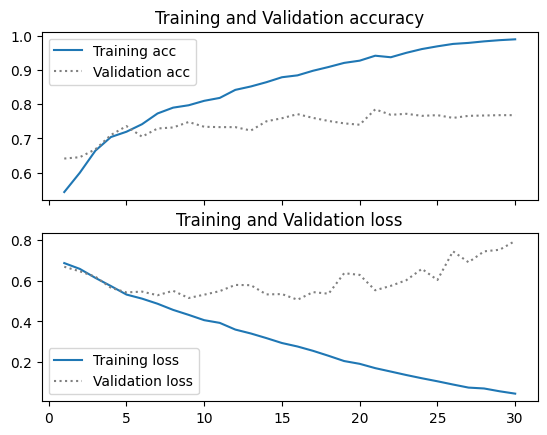

In [8]:
#plot the loss and acc through the epochs when training
import matplotlib.pyplot as plt
acc=history.history["acc"]
val_acc=history.history["val_acc"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1,len(acc)+1)

f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
ax1.plot(epochs,acc,label="Training acc")
ax1.plot(epochs,val_acc,color="grey",ls=":",label="Validation acc")
ax1.set_title("Training and Validation accuracy")
ax1.legend()
ax2.plot(epochs,loss,label="Training loss")
ax2.plot(epochs,val_loss,color="grey",ls=":",label="Validation loss")
ax2.set_title("Training and Validation loss")
ax2.legend()

plt.show()

1/1 [==============================] - 0s 34ms/step


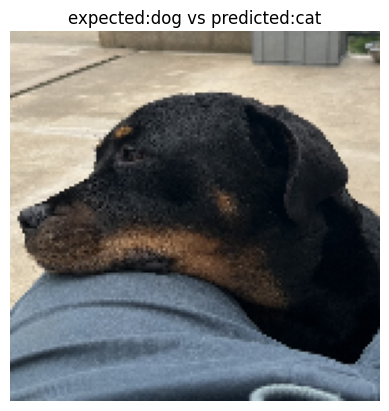

In [17]:
#testing model prediction with my dog's picture
import cv2
img_t=cv2.imread("mine.jpg",cv2.IMREAD_COLOR)
img_t=cv2.cvtColor(img_t,cv2.COLOR_BGR2RGB)
img_t=img=cv2.resize(img_t,(150,150))
def get_key(dic,item):
    item=int(item)
    for key,value in dic.items():
        if value==item:
            return key
    return None
        

plt.imshow(img_t)
label_pre=small_model.predict(img_t.reshape((1,)+img_t.shape))

plt.title("expected:dog vs predicted:{}".
          format(get_key(train_g.class_indices,label_pre[0][0])))
plt.axis("off")
plt.show()

In [24]:
#Testing the small model with the test images
test_loss,test_acc=small_model.evaluate(test_g)
print("Test accuracy: {:.2f}".format(test_acc))

50/50 [==============================] - 2s 29ms/step - loss: 0.8034 - acc: 0.7560
Test accuracy: 0.76
